# Bike Sharing Count Prediction
In this notebook, I intend to make a model that predicts the count of casual and registered users given the environmental and seasonal settings. After a short EDA and normalization, I'll be using Gradient Boosting, Random Forest, and a simple DNN. 

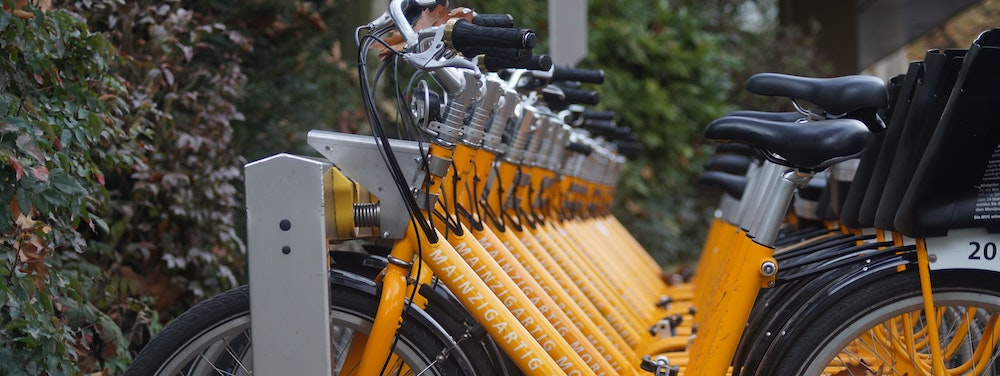
<span>Photo by <a href="https://unsplash.com/@millerthachiller?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Pascal Müller</a> on <a href="https://unsplash.com/s/photos/bike-sharing?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a></span>



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
import tensorflow as tf

## Loading the data

According to the description of the dataset, the enviromental features (4 columns of temp, atemp, hum and windspeed) are normalized. I think the temp and atemp (feels like temperature) are too correlated, so I discard atemp here. I need the data in its original scale, so I'll reverse the normalization according to the description below from the dataset owner:

- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)

In [ ]:
df = pd.read_csv('/kaggle/input/bike-share-daily-data/bike_sharing_daily.csv', index_col ='dteday')
df.drop('instant', axis=1, inplace=True)
df['temp'] = df['temp']*41
df['hum'] = df['hum']*100
df['windspeed'] = df['windspeed']*100
df


In [ ]:
df.describe().T

## Any missing data? 


Good, there is no missing data. 

In [ ]:
df.isnull().values.any()

## Visualization of time series

In [ ]:
df[['temp', 'hum', 'windspeed']].plot(figsize=(10, 5))
df[['casual', 'registered']].plot(figsize=(10, 5))

## Cross Correlation Matrix

In [ ]:
plt.subplots(figsize=(8, 6))
sns.heatmap(df.corr())

## Split the data
Let's make a simple manual split for now.

In [ ]:
n = len(df)
train_df = df[:int(0.8*n)].copy()
test_df = df[int(0.8*n):].copy()

## Normalize the data
We just need to normalize the non-categorical data. So, first we define them and then normalize those columns only.

In [ ]:
non_cat = ['temp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
train_mean = train_df[non_cat].mean()
train_std = train_df[non_cat].std()

train_df.loc[:, non_cat] = (train_df.loc[:, non_cat] - train_mean) / train_std
test_df.loc[:, non_cat] = (test_df.loc[:,non_cat] - train_mean) / train_std


Let's plot the probability density of the data using violin data to make sure our normalization looks good.

In [ ]:
df_std = (df[non_cat] - train_mean) / train_std
df_melt = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_melt)
_ = ax.set_xticklabels(df[non_cat].keys(), rotation=90)

## Feature selection

There are two types of input data:
- Seasonal data
- Weather data

and the output of the model is the bike user count which can be found in three columns of:

- casual 
- registered
- cnt (sum of the causual and registered)

We can drop 'cnt' as it's just the total count of users. I experimented with seasonal data only or weather data only as the input to the model. But, the performance was better when all input features are used.

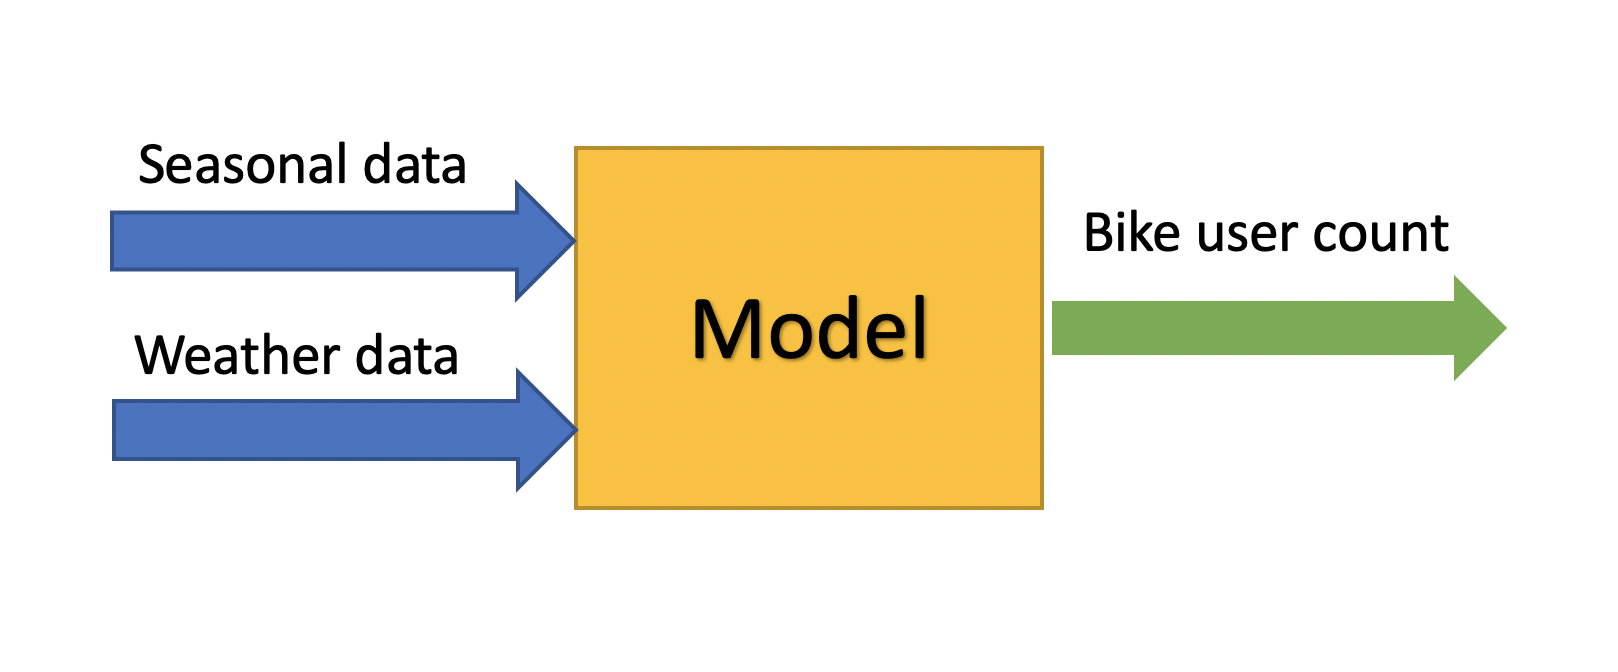

In [ ]:
# separate input and output in each dataset
input_columns = ['season', 'yr', 'mnth', 'weekday', 'workingday','temp', 'hum', 'windspeed']
output_columns = ['casual', 'registered']



train_in = train_df[input_columns].to_numpy()
test_in = test_df[input_columns].to_numpy()


train_out = train_df[output_columns].to_numpy()
test_out = test_df[output_columns].to_numpy()

print(f'train_in shape: {train_in.shape}')
print(f'test_in shape: {test_in.shape}')
print(f'train_out shape: {train_out.shape}')
print(f'test_out shape: {test_out.shape}')

## Denormalizing function

Before evaluating the models, we invert the normalization and compare the predictions and true values in their actual scale. We use the following function to invert the normalization.

In [ ]:
# mean and std to be used for inverting the normalizatioin
_mean = train_mean[output_columns].values
_std = train_std[output_columns].values

# Denormalize the data
def denorm(data, mean, std):
    data_denorm = data * std + mean
    return data_denorm


## Models

Let's define a function to evaluate the models.

In [ ]:
def evaluate_model(model, train_in, train_out, test_in, test_out):
    print('\n***** Training performance: *****') 
    train_pred = model.predict(train_in)
    train_pred_denorm = denorm(train_pred, _mean, _std) 
    train_out_denorm = denorm(train_out, _mean, _std) 
    train_mae = round(mean_absolute_error(train_pred_denorm, train_out_denorm), 2)
    print('MAE = ', train_mae)


    print('\n***** Testing performance: *****') 
    test_pred = model.predict(test_in)
    test_pred_denorm = denorm(test_pred, _mean, _std) 
    test_out_denorm = denorm(test_out, _mean, _std) 
    test_mae = round(mean_absolute_error(test_pred_denorm, test_out_denorm), 2)
    print('MAE = ', test_mae)

    for i, col in enumerate(output_columns):   
        plt.figure(figsize=(10,5))
        plt.plot(test_pred_denorm[:, i])
        plt.plot(test_out_denorm[:, i])
        plt.legend(['predict', 'true'])
        plt.title(f'Predict vs. ground truth for {col}')
    return train_mae, test_mae

## Gradient Boosting

In [ ]:
# Creating a MultiOutputRegressor object with GradientBoostingRegressor estimtor 
# This assumes that the outputs are independent of each other, which might not be a correct assumption. 
gbr = MultiOutputRegressor(GradientBoostingRegressor(random_state=0))

print('\n====== GradientBoostingRegressor =====')
gbr.fit(train_in, train_out) 
gbr_train_mae, gbr_test_mae = evaluate_model(gbr, train_in, train_out, test_in, test_out)

## Random Forest

In [ ]:
rfr = RandomForestRegressor(n_estimators=100, criterion='mae', random_state=0)
print('\n====== RandomForestRegressor =====')
rfr.fit(train_in, train_out) 
rfr_train_mae, rfr_test_mae = evaluate_model(rfr, train_in, train_out, test_in, test_out)

## DNN

In [ ]:
nn = tf.keras.Sequential([
    tf.keras.layers.Dense(32, input_shape=(len(input_columns),)),
    tf.keras.layers.Dense(len(output_columns))
])

print(nn.summary())


In [ ]:
MAX_EPOCHS = 100

def compile_and_fit(model, train_in, train_out, test_in, test_out, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(train_in, train_out, epochs=MAX_EPOCHS,
                      validation_data=(test_in, test_out),
                      callbacks=[early_stopping],
                      batch_size = 32, verbose=0)
    return history

In [ ]:
tf.keras.backend.clear_session()
history = compile_and_fit(nn, train_in, train_out, test_in, test_out)
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.figure()
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.legend(['mean_absolute_error', 'val_mean_absolute_error'])

In [ ]:
nn_train_mae, nn_test_mae = evaluate_model(nn, train_in, train_out, test_in, test_out)

## Comparing the models

In [ ]:
print('Model: Train MAE - Test MAE')
print(f'Gradient Boosting: {gbr_train_mae} - {gbr_test_mae }')
print(f'Random Forest: {rfr_train_mae} - {rfr_test_mae }')
print(f'DNN: {nn_train_mae} - {nn_test_mae }')


It looks like the best results based on test MAE is driven from Gradient Boosting method. Perhaps the other models specially DNN can be tuned to achieve at least the same level of performance. Please let me know if you have any suggestion to improve the models. Thanks for your feedback.